<a href="https://colab.research.google.com/github/apthagowda97/computer_vision_poc/blob/master/gan/notebook/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [230]:
import os
import cv2
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader

import torch.nn.parallel
import torchvision.utils as vutils
from torch.autograd import Variable
from torchsummary import summary

In [145]:
device = "cuda:0"

In [275]:
batchSize = 16
imageSize = 64

In [142]:
%%shell

wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
tar -xzf flower_photos.tgz

--2020-09-01 08:28:04--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 64.233.187.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  61.0MB/s    in 3.6s    

2020-09-01 08:28:08 (61.0 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [276]:
image_name = [];flower_name = []
for dir_name in os.listdir('flower_photos'):
  if os.path.isdir(os.path.join('flower_photos',dir_name)):
    names = os.listdir(os.path.join('flower_photos',dir_name))
    image_name.extend(names);flower_name.extend([dir_name]*len(names))

In [277]:
flower_df = pd.DataFrame(data={'flower_name':flower_name,'image_name':image_name})
flower_df['image_path'] = flower_df['flower_name']+'/'+flower_df['image_name']

In [278]:
class Flower_dataset(Dataset):
    def __init__(self,df,transform=None):
        self.df = df
        self.transform = transform

        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image_path']
        image = plt.imread(os.path.join('flower_photos',image_path))
        if self.transform is not None:
            image = self.transform(image)
        return {'image':image}

In [279]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((imageSize,imageSize)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [280]:
roses = flower_df[flower_df['flower_name']=="roses"].reset_index(drop=True)

In [281]:
dataset = Flower_dataset(df=flower_df, transform=transform)
dataloader = DataLoader(dataset , batch_size=batchSize, num_workers=4, shuffle=True, drop_last=False)

In [282]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [283]:
class G(nn.Module):

    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [284]:
netG = G()
netG.to(device)
netG.apply(weights_init)
summary(netG,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [285]:
class D(nn.Module):
    def __init__(self):
        super(D,self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,128,4,2,1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),            
            nn.Conv2d(128,256,4,2,1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),           
            nn.Conv2d(256,512,4,2,1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Flatten(),
            nn.Linear((512*4*4),1,bias=False),
            nn.Sigmoid()
            
        )
        
    def forward(self,input):
        output = self.main(input)
        return output.view(-1)
    

In [286]:
netD = D()
netD.to(device)
netD.apply(weights_init)
summary(netD,input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
          Flatten-13                 [-1, 8192]               0
           Linear-14                   

In [287]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [288]:
for epoch in range(30):

    for i, data in enumerate(dataloader, 0):
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        netD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real = data['image']
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input.to(device))
        errD_real = criterion(output, target.to(device))
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise.to(device))
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target.to(device))
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target.to(device))
        errG.backward()
        optimizerG.step()

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 30, i, len(dataloader), errD.data, errG.data))

[0/30][229/230] Loss_D: 0.2140 Loss_G: 6.9337
[1/30][229/230] Loss_D: 0.3098 Loss_G: 3.7287
[2/30][229/230] Loss_D: 1.1290 Loss_G: 1.5961
[3/30][229/230] Loss_D: 1.0742 Loss_G: 2.6211
[4/30][229/230] Loss_D: 1.6924 Loss_G: 7.0022
[5/30][229/230] Loss_D: 0.5734 Loss_G: 6.6850
[6/30][229/230] Loss_D: 1.5829 Loss_G: 5.2961
[7/30][229/230] Loss_D: 0.6430 Loss_G: 4.2244
[8/30][229/230] Loss_D: 0.4264 Loss_G: 3.3973
[9/30][229/230] Loss_D: 0.5058 Loss_G: 3.4542
[10/30][229/230] Loss_D: 0.7196 Loss_G: 2.9423
[11/30][229/230] Loss_D: 1.7305 Loss_G: 2.0148
[12/30][229/230] Loss_D: 2.1441 Loss_G: 1.4026
[13/30][229/230] Loss_D: 0.6377 Loss_G: 5.7264
[14/30][229/230] Loss_D: 0.6307 Loss_G: 3.3071
[15/30][229/230] Loss_D: 0.5259 Loss_G: 4.3201
[16/30][229/230] Loss_D: 1.4991 Loss_G: 7.0989
[17/30][229/230] Loss_D: 1.0503 Loss_G: 6.3595
[18/30][229/230] Loss_D: 0.5861 Loss_G: 5.4069
[19/30][229/230] Loss_D: 0.1689 Loss_G: 7.1196
[20/30][229/230] Loss_D: 0.2545 Loss_G: 4.1178
[21/30][229/230] Loss_D

In [291]:
fake_img_list = []
noise = Variable(torch.randn(batchSize, 100, 1, 1))
fake = netG(noise.to(device)).detach().cpu()
fake_img_list.append(vutils.make_grid(fake, padding=4, normalize=True))

Text(0.5, 1.0, 'fake_image')

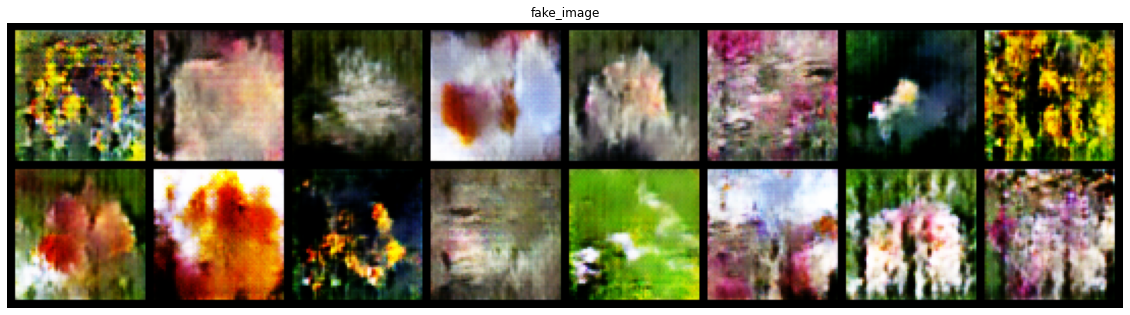

In [292]:
plt.figure(figsize=(20,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in fake_img_list]
plt.title('fake_image')

In [293]:
real_img_list = []
real_image = next(iter(dataloader))
real_img_list.append(vutils.make_grid(real_image['image'], padding=4, normalize=True))

Text(0.5, 1.0, 'real_image')

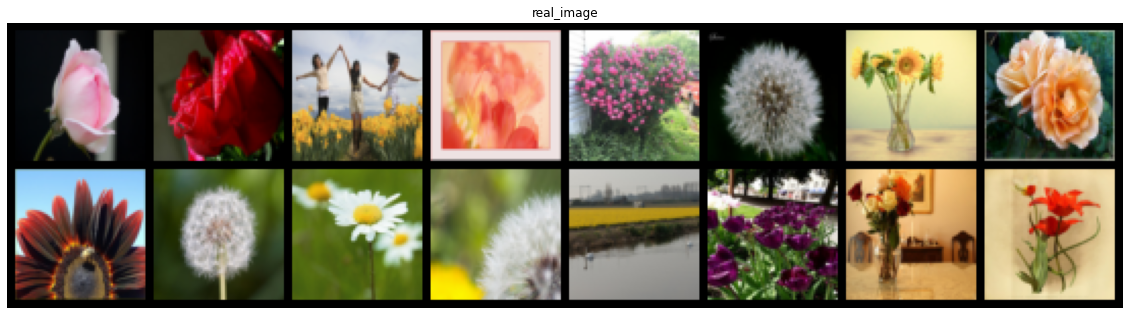

In [294]:
plt.figure(figsize=(20,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in real_img_list]
plt.title('real_image')